**IMPORT ALL NECESSARY PYTHON MODULES AND LIBRARIES AND NECCESSARY DATASET SETUP AND SOFTWARE REQUIREMENTS**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [2]:
import keras
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, Add, Activation
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers import GlobalMaxPooling2D, Multiply, Reshape, Permute

In [3]:
!pip install kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omsubratodey1","key":"f7f32820a52bef66180902f439a9887d"}'}

In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/kaggle.json'

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [01:09<00:00, 30.2MB/s]
100% 1.68G/1.68G [01:09<00:00, 26.0MB/s]


In [8]:
!unzip deepfake-and-real-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [9]:
!ls

Dataset  deepfake-and-real-images.zip  kaggle.json  sample_data


**MINIMIZE THE DATASET FOR EASIER COMPUTATON AND WITHIN KERNEL LIFETIME**

In [10]:
import os
import shutil
from sklearn.utils import shuffle

def reduce_dataset(src_dir, dest_dir, num_samples):
    # Create destination directories if they don't exist
    os.makedirs(os.path.join(dest_dir, 'Real'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'Fake'), exist_ok=True)

    # Function to reduce and copy files
    for category in ['Real', 'Fake']:
        src_path = os.path.join(src_dir, category)
        dest_path = os.path.join(dest_dir, category)
        files = os.listdir(src_path)
        files = shuffle(files)
        for file in files[:num_samples]:
            shutil.copy(os.path.join(src_path, file), os.path.join(dest_path, file))

# Define paths from the previous code
train_dir = '/content/Dataset/Train'
valid_dir = '/content/Dataset/Validation'
test_dir = '/content/Dataset/Test'

# Reduce datasets (adjust the number of samples as per your need)
reduce_dataset(train_dir, '/content/reduced_Dataset/Train', 1000)
reduce_dataset(valid_dir, '/content/reduced_Dataset/Validation', 100)
reduce_dataset(test_dir, '/content/reduced_Dataset/Test', 100)

In [11]:
train_dir = '/content/reduced_Dataset/Train'
valid_dir = '/content/reduced_Dataset/Validation'
test_dir = '/content/reduced_Dataset/Test'

In [12]:
def normalize_image(image, labels):
  image = tf.cast(image, tf.float32) / 255.0
  return image, labels

In [13]:
IMG_SIZE = (256, 256)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode = 'categorical', batch_size = 128, image_size= IMG_SIZE)
validation_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir, label_mode = 'categorical', batch_size = 128, image_size= IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode = 'categorical', batch_size = 128, image_size= IMG_SIZE, shuffle = False)

Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [14]:
train_data = train_data.map(normalize_image)
validation_data = validation_data.map(normalize_image)
test_data = test_data.map(normalize_image)

In [25]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')
])

In [26]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 62, 62, 128)         │          46,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 62, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 31, 31, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 31, 31, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 10, 10, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 10, 10, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 10, 10, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       6,554,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,148,994 (31.09 MB)

 Trainable params: 8,146,690 (31.08 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [27]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001), loss = 'BinaryCrossentropy',  metrics=['accuracy'])
model_checkpoint = ModelCheckpoint(filepath='/kaggle/working/model_epoch128_{epoch:02d}.keras', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

**BATCH 1 OF EPOCHS**

In [28]:
history = model.fit(train_data, epochs = 50, validation_data = validation_data, callbacks=[model_checkpoint, early_stopping])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 349s 22s/step - accuracy: 0.5247 - loss: 1.0918 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 327s 18s/step - accuracy: 0.5701 - loss: 1.0016 - val_accuracy: 0.5000 - val_loss: 0.6970
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 320s 18s/step - accuracy: 0.6234 - loss: 0.8910 - val_accuracy: 0.5000 - val_loss: 0.6987
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 320s 18s/step - accuracy: 0.6284 - loss: 0.8802 - val_accuracy: 0.5000 - val_loss: 0.7011
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 325s 18s/step - accuracy: 0.6783 - loss: 0.8089 - val_accuracy: 0.5000 - val_loss: 0.7015
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 320s 18s/step - accuracy: 0.6792 - loss: 0.7526 - val_accuracy: 0.5000 - val_loss: 0.7051


**BATCH 2 OF EPOCHS**

In [30]:
# Load the latest saved model
latest_model_path = '/kaggle/working/model_epoch128_*.keras'
import glob
list_of_files = glob.glob(latest_model_path) # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
model = keras.models.load_model(latest_file)

# Continue training from the loaded model
history = model.fit(train_data, epochs = 50, initial_epoch=6, validation_data = validation_data, callbacks=[model_checkpoint, early_stopping])

Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 295s 18s/step - accuracy: 0.5902 - loss: 1.0030 - val_accuracy: 0.5000 - val_loss: 0.6971
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 294s 18s/step - accuracy: 0.6152 - loss: 0.9148 - val_accuracy: 0.5000 - val_loss: 0.7000
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 331s 19s/step - accuracy: 0.6293 - loss: 0.8853 - val_accuracy: 0.5000 - val_loss: 0.7008
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 313s 18s/step - accuracy: 0.6527 - loss: 0.8036 - val_accuracy: 0.5000 - val_loss: 0.7000
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 290s 18s/step - accuracy: 0.6938 - loss: 0.7500 - val_accuracy: 0.5000 - val_loss: 0.6990


**BATCH 3 OF EPOCHS**

In [31]:
# Load the latest saved model
latest_model_path = '/kaggle/working/model_epoch128_*.keras'
import glob
list_of_files = glob.glob(latest_model_path) # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
model = keras.models.load_model(latest_file)

# Continue training from the loaded model
history = model.fit(train_data, epochs = 50, initial_epoch=11, validation_data = validation_data, callbacks=[model_checkpoint, early_stopping])

Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 311s 19s/step - accuracy: 0.5951 - loss: 0.9895 - val_accuracy: 0.5000 - val_loss: 0.6969
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 313s 19s/step - accuracy: 0.6017 - loss: 0.9355 - val_accuracy: 0.5000 - val_loss: 0.7001
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 305s 19s/step - accuracy: 0.6269 - loss: 0.8881 - val_accuracy: 0.5000 - val_loss: 0.7046
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 327s 20s/step - accuracy: 0.6763 - loss: 0.7839 - val_accuracy: 0.5000 - val_loss: 0.7054
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 356s 19s/step - accuracy: 0.6858 - loss: 0.7718 - val_accuracy: 0.5000 - val_loss: 0.7055


In [48]:
list_of_files = glob.glob(latest_model_path)
latest_file = max(list_of_files, key=os.path.getctime)
model = keras.models.load_model(latest_file)

# Continue training from the loaded model
history = model.fit(train_data, epochs = 50, initial_epoch=16, validation_data = validation_data, callbacks=[model_checkpoint, early_stopping])

Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 312s 19s/step - accuracy: 0.5815 - loss: 0.9777 - val_accuracy: 0.5000 - val_loss: 0.6967
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 302s 19s/step - accuracy: 0.6239 - loss: 0.8881 - val_accuracy: 0.5000 - val_loss: 0.7006
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 380s 22s/step - accuracy: 0.6424 - loss: 0.8648 - val_accuracy: 0.5000 - val_loss: 0.7022
Epoch 20/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 298s 18s/step - accuracy: 0.6589 - loss: 0.8349 - val_accuracy: 0.5000 - val_loss: 0.7022
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 288s 18s/step - accuracy: 0.6826 - loss: 0.7714 - val_accuracy: 0.5000 - val_loss: 0.7051


**KERNEL TERMINATES THE PROCESS AT EVERY 5 TO 6 EPOCHS IN EACH CELL.**

**IN ABOVE EPOCHS WE CAN SEE THAT THE PERFORMANCE METRICS DOESN'T VARY MUCH SO WE WILL STOP HERE AS THE ACCURACY OF THE MODEL DOES NOT INCREASE FURTHER**

In [49]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Get predictions on the test data
y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true = np.argmax(y_true, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1-score
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F1-score: 0.33333333333333326
Sensitivity: 1.0
Specificity: 0.0

Confusion Matrix:
 [[  0 100]
 [  0 100]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.50      1.00      0.67       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:14

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4062 - loss: 0.7086
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.6973
Test Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1-Score: 0.3333
AUC: 0.4957
Kappa: 0.0000
MCC: 0.0000


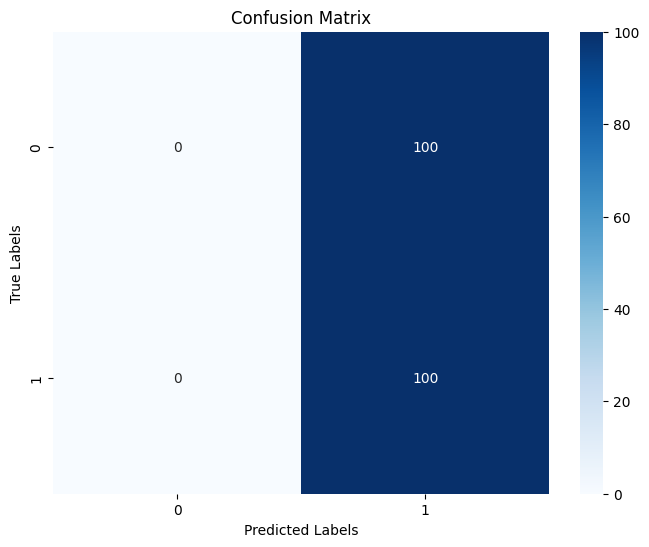

In [50]:
test_loss, test_accuracy = model.evaluate(test_data)

# Generate predictions on the test data
y_pred = model.predict(test_data)
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Calculate performance metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true_classes, y_pred_classes)
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)
mcc = matthews_corrcoef(y_true_classes, y_pred_classes)

# Assuming y_pred is the predicted probability for each class
try:
  auc = roc_auc_score(y_true, y_pred)
except ValueError:
  auc = 0  # or handle the error appropriately if necessary

# Calculate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Print performance metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Kappa: {kappa:.4f}")
print(f"MCC: {mcc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



**FROM ABOVE CONFUSION MATRIX WE CAN CONCLUDE THAT FOR ALL FAKE IMAGES, THE MODEL CAN PREDICT AND GIVE THE RIGHT RESULT AS WELL , BUT FOR ALL REAL IMAGES IT WILL NOT WORK CORRECTLY**

In [51]:
with open('/kaggle/working/history128.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [52]:
!zip -r file.zip /kaggle/working
from IPython.display import FileLink
FileLink(r'file.zip')

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/model_epoch128_01.keras (deflated 9%)
updating: kaggle/working/history128.pkl (deflated 46%)


/content/file.zip

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        Real       0.00      0.00      0.00       100
        Fake       0.50      1.00      0.67       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



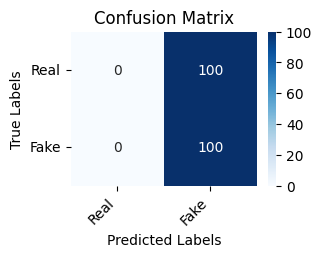

In [53]:
predicted_probs = model.predict(test_data, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)
test_labels = [labels for _ , labels in test_data]
test_labels = np.concatenate(test_labels, axis=0)
test_labels_0 = np.argmax(test_labels,axis=1)
cm = confusion_matrix(test_labels_0, predicted_labels)
accuracy = accuracy_score(test_labels_0, predicted_labels)
cm, accuracy

class_names = ['Real', 'Fake']
report = classification_report(test_labels_0, predicted_labels, target_names=class_names)
print(report)

plt.figure(figsize=(3, 2))
class_names = ['Real', 'Fake']
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)

heatmap.set_xticklabels(class_names, rotation=45, ha='right')
heatmap.set_yticklabels(class_names, rotation=0)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

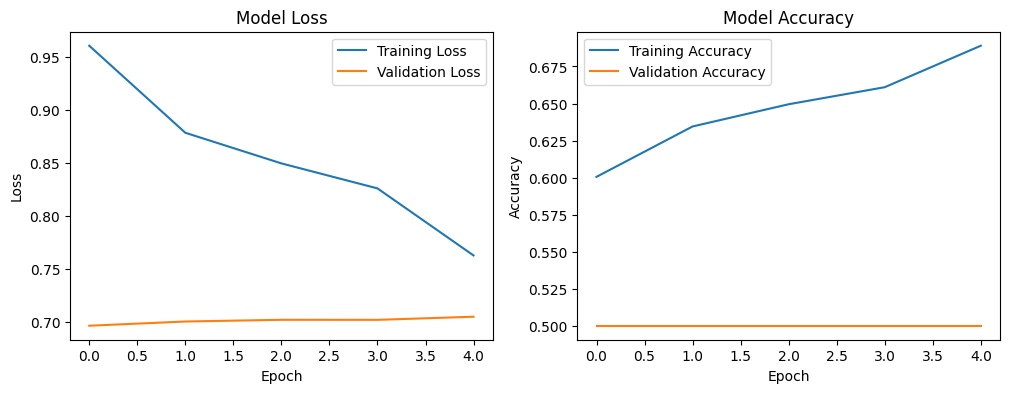

In [54]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [43]:
from sklearn.metrics import classification_report

# Assuming y_true_classes and y_pred_classes are defined as in your previous code
class_names = ['Real', 'Fake']
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

        Real       0.00      0.00      0.00       100
        Fake       0.50      1.00      0.67       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**MISSCLASSIFIED EXAMPLE**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


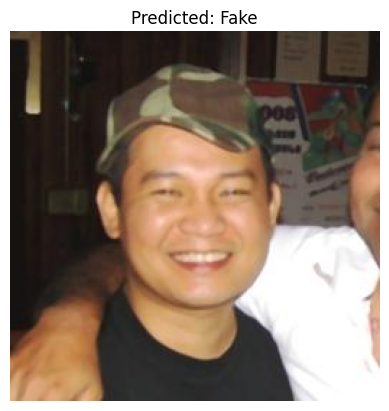

The model predicts the image as: Fake


In [47]:
# prompt: Generate code for testing the above CNN model on test images

import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

# Function to load and preprocess an image for prediction
def load_and_preprocess_image(img_path, target_size=(256, 256)):
  img = image.load_img(img_path, target_size=target_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0  # Normalize pixel values
  return img_array

# Path to your test image
test_image_path = '/content/reduced_Dataset/Test/Real/real_3409.jpg' # Replace with the actual path to your test image

# Load and preprocess the image
img_array = load_and_preprocess_image(test_image_path)

# Make prediction using the loaded model
prediction = model.predict(img_array)

# Get the predicted class (0 or 1)
predicted_class = np.argmax(prediction)

# Map the predicted class to a label
class_labels = ['Real', 'Fake']
predicted_label = class_labels[predicted_class]

# Display the image and the prediction
plt.imshow(image.load_img(test_image_path))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

print(f"The model predicts the image as: {predicted_label}")



**CORRECTLY CLASSIFIED**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


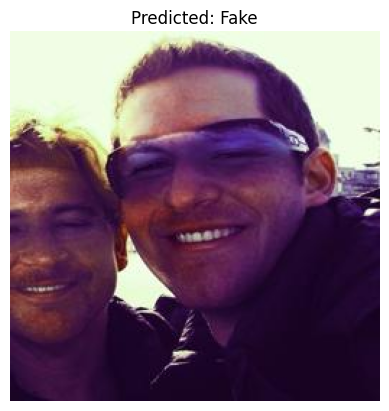

The model predicts the image as: Fake


In [61]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

# Function to load and preprocess an image for prediction
def load_and_preprocess_image(img_path, target_size=(256, 256)):
  img = image.load_img(img_path, target_size=target_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0  # Normalize pixel values
  return img_array

# Path to your test image
test_image_path = '/content/reduced_Dataset/Test/Fake/fake_2403.jpg'

# Load and preprocess the image
img_array = load_and_preprocess_image(test_image_path)

# Make prediction using the loaded model
prediction = model.predict(img_array)

# Get the predicted class (0 or 1)
predicted_class = np.argmax(prediction)

# Map the predicted class to a label
class_labels = ['Real', 'Fake']
predicted_label = class_labels[predicted_class]

# Display the image and the prediction
plt.imshow(image.load_img(test_image_path))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

print(f"The model predicts the image as: {predicted_label}")